In [6]:
import base64
import os
import pickle
import re
import time
import nltk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

from collections import Counter
from dotenv import dotenv_values
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from PIL import Image
from textblob import TextBlob
from wordcloud import WordCloud, ImageColorGenerator

In [7]:
# Download required nltk packages and set Pandas options
nltk.download()
pd.set_option('display.max_colwidth', None)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


# Configuration

Setup the Twitter API configuration and Twitter Search API parameters for fetching the datasets.

In [8]:
# setup client credentials for authorization
config = dotenv_values('../.env')
CLIENT_ID = config['TWITTER_CLIENT_KEY']
CLIENT_SECRET = config['TWITTER_CLIENT_SECRET']
CLIENT_BEARER_TOKEN = config['TWITTER_BEARER_TOKEN']

In [9]:
# Setup Twitter API configuration
client_key = CLIENT_ID
client_secret = CLIENT_SECRET
bearer_token = CLIENT_BEARER_TOKEN

key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')

base_url = 'https://api.twitter.com/'
auth_endpoint = base_url + 'oauth2/token'

auth_headers = { 
	'Authorization': 'Basic {}'.format(b64_encoded_key),
	'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8' }

auth_data = { 'grant_type': 'client_credentials' }

# Get access token
response = requests.post(auth_endpoint, headers=auth_headers, data=auth_data)
json_data =  response.json()
access_token = json_data['access_token']

In [10]:
# Setup the queries and base parameters to execute to seed data
queries = {
	'basketball': '#olympics basketball -is:retweet lang:en',
	'biking': '#olympics biking -is:retweet lang:en',
	'diving': '#olympics diving -is:retweet lang:en',
	'gymnastics': '#olympics gymnastics -is:retweet lang:en',
	'skateboard': '#olympics skateboard -is:retweet lang:en',
	'surfing': '#olympics surfing -is:retweet lang:en',
	'track': '#olympics track -is:retweet lang:en',
	'volleyball': '#olympics volleyball -is:retweet lang:en',
}

max_tweets = 5000
tweet_limit = 100

search_url = base_url + '2/tweets/search/recent'

# Data Request
Determine if the pickled output exists and re-request the Twitter data if it does not.

In [11]:
# Define a method for obtaining tweet data
def get_tweets(access_token, query, max_tweets=10, tweet_limit=10):
	"""Retrieve tweets from the recent search API.
	Args
	----
		access_token (str): A valid bearer token for making Twitter API requests.
		query (str): A valid Twitter query string for filtering the search tweets.
		max_tweets (int): The maximum number of tweets to collect in total.
		tweet_limit (int): The number of maximum tweets per API request. 
    """

	page_token = None
	tweet_data = []

	search_headers = { 
		'Authorization': 'Bearer {}'.format(access_token), 
		'User-Agent': 'v2FullArchiveSearchPython'
	}

	# Divides the max tweets into the appropriate number of requests based on the tweet_limit.
	for i in range(max_tweets // tweet_limit - 1):
		search_parameters = {
			'query': query,
			'max_results': tweet_limit,
			'tweet.fields': 'created_at,conversation_id'
		}
		# print(f'\tRequest {i + 1}: {query}')
		
		# If we reach the 2nd page of results, add a next_token attribute to the search parameters
		if i > 0: 
			search_parameters['next_token'] = page_token

		response = requests.get(search_url, headers=search_headers, params=search_parameters)
		if response.status_code != 200:
			print(f'\tError occurred: Status Code{response.status_code}: {response.text}')
		else:
			# Check for a result count before doing anything futher; if result_count we have data
			if response.json()['meta']['result_count'] > 0:
				tweet_data.extend(response.json()['data'])
				
				# If a 'next_token' exists, then update the page token to continue pagination
				if 'next_token' in response.json()['meta']:
					page_token = response.json()['meta']['next_token']
			else:
				print(f'\tNo data returned for query!')
				break
		print(f'\t[{len(tweet_data)}] results collected')
		time.sleep(1) # pause in between requests per twitter robots.txt
	return tweet_data

In [12]:
get_path = lambda name: '../data/' + name + '-tweets.pkl' # store filenaming syntax

# Check if we need to re-process any data, serialize it, and store it
for (k, v) in queries.items():
	if not os.path.exists(get_path(k)):
		print(f'Processing {k}')
		tweet_data = get_tweets(access_token, v, max_tweets, tweet_limit)
		if tweet_data:
			with open(get_path(k), 'wb') as f:
				pickle.dump(tweet_data, f)
				print(f'Tweet data for {k} dumped to .pkl')
	else:
		print(f'Dataset already exists for {get_path(k)}!')
print('Finished data requesting')

Dataset already exists for ../data/basketball-tweets.pkl!
Dataset already exists for ../data/biking-tweets.pkl!
Dataset already exists for ../data/diving-tweets.pkl!
Dataset already exists for ../data/gymnastics-tweets.pkl!
Dataset already exists for ../data/skateboard-tweets.pkl!
Dataset already exists for ../data/surfing-tweets.pkl!
Dataset already exists for ../data/track-tweets.pkl!
Dataset already exists for ../data/volleyball-tweets.pkl!
Finished data requesting


# De-Serialize & Clean Data

Read the cached tweet data from the serialized pickle files and store into corresponding dataframes. 

## Data Preparation

* Remove duplicate tweets
* Convert data types
* Handle NaN values

In [13]:
# Deserialize all of the datasets into a single dataset
olympic_df = pd.DataFrame(columns=['id', 'created_at', 'conversation_id', 'text'])

for s in queries.keys():
	print(f'Deserializing {s}')
	df = pd.DataFrame(pd.read_pickle('../data/' + s + '-tweets.pkl'))
	df['sport'] = s
	olympic_df = olympic_df.append(df, ignore_index=True)

olympic_df.shape

Deserializing basketball
Deserializing biking
Deserializing diving
Deserializing gymnastics
Deserializing skateboard
Deserializing surfing
Deserializing track
Deserializing volleyball


(30554, 6)

In [14]:
olympic_df.dtypes

id                 object
created_at         object
conversation_id    object
text               object
sport              object
withheld           object
dtype: object

In [15]:
# Convert data types
olympic_df.id = olympic_df.id.astype('int32')
olympic_df.created_at = pd.to_datetime(olympic_df.created_at)
olympic_df.conversation_id = olympic_df.conversation_id.astype('int32')
olympic_df.drop(['withheld'], axis=1, inplace=True) # drop the unnecessary withheld column
olympic_df.dtypes

id                               int32
created_at         datetime64[ns, UTC]
conversation_id                  int32
text                            object
sport                           object
dtype: object

In [16]:
# Drop duplicates prior to any processing
olympic_df.drop_duplicates(inplace=True)
olympic_df.shape

(23330, 5)

In [17]:
olympic_df.isna().sum()

id                 0
created_at         0
conversation_id    0
text               0
sport              0
dtype: int64

## Data Cleansing
* Remove puncutation
* Remove user mentions
* Remove hashtags
* Remove URLs

In [18]:
# Remove user mentions, hashtags, and urls from a text string.
stops = stopwords.words('english')
stop_words = Counter(stops)

def clean_tweet_text(text):
	"""Cleanses a tweet text of user mentions, links, hashtags, special characters, and emojis."""

	# Define any custom replacement pattern and join into an aggregated pattern
	replacements = [
		r'(@[\w]+)',
		r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
		r'(#\w+)',
		r'[\$&+,:;=?@#|\'<>.^*()%!-/]',
		r'\n',
		r'[0-9]+'
	]
	aggregate_pattern = r'|'.join(replacements)
	clean_text = re.sub(aggregate_pattern, '', text) # make regex substitutions in one pass
	
	# Return the unicode-stripped text in lowercase
	return clean_text.encode(encoding='ascii', errors='ignore').decode('ascii').lower()

# Make replacements
olympic_df['clean_text'] = olympic_df.text.apply(lambda row : clean_tweet_text(row))
olympic_df.sample(5)

,id,created_at,conversation_id,text,sport,clean_text
22312,316121089,2021-08-07 21:47:49+00:00,316121089,Hassan cold on the track #Olympics,track,hassan cold on the track
13688,-1189720064,2021-08-08 17:11:56+00:00,-1151873024,"@EntradaBooks Thank You, Simone Biles - HeadphonesThoughts https://t.co/LzMcAVIfDF… via @HeadphonesTblog #Simone #Gymnastics #TokyoOlympics #SimoneBiles #mentalhealth #mentalillness #MentalHealthAwareness #Olympics #USAGymnastics @Simone_Biles @Olympics",gymnastics,thank you simone biles headphonesthoughts via
23979,987058177,2021-08-07 12:13:20+00:00,987058177,WHAT A LEGEND 💯💯\nFirst ever track and field medal and that too gold😭❤️\nCouldn’t have been better \n\n#gold #Olympics #IndiaTodayAtOlympics https://t.co/PT26D9eTio,track,what a legend first ever track and field medal and that too goldcouldnt have been better
25788,-1005084671,2021-08-09 03:05:46+00:00,-1005084671,"#Japan earns great respect and gratitude for their #Olympics hosting in a tough situation. Very entertaining, especially #trackandfield and #Volleyball for me. That women's 4x400 relay...🔥 https://t.co/0hU5qohyXV",volleyball,earns great respect and gratitude for their hosting in a tough situation very entertaining especially and for me that womens x relay
23451,-778694655,2021-08-07 12:26:19+00:00,-778694655,*_History Made in Tokyo #Olympics \n\n#India* gets #FirstGold medal* in *track and field events* in #Olympicshistory*!! 💪💪\n\n#Neeraj Chopra wins #Gold #Medal in Men's #Javelin Throw competition. \n\nThis is the highest medal tally* for #India in any #Olympics with #7medals*\n👏👏👏,track,_history made in tokyo gets medal in track and field events in chopra wins in mens throw competition this is the highest medal tally for in any with


In [19]:
# Remove all stop words
olympic_df['clean_no_stops'] = olympic_df.clean_text.apply(
	lambda row: [ word.strip() for word in row.split() if word.strip() not in stop_words ]
)
olympic_df.sample(5)

,id,created_at,conversation_id,text,sport,clean_text,clean_no_stops
28034,957718529,2021-08-08 00:02:39+00:00,957718529,Why is there a player on each team in Volleyball in red instead of team uniform??????? #Olympics #Tokyo2020,volleyball,why is there a player on each team in volleyball in red instead of team uniform,"[player, team, volleyball, red, instead, team, uniform]"
1206,248872960,2021-08-08 03:33:31+00:00,-1328214009,WOOTS I SAW MEGAN RAPINOE WATCHING THE MATCH 👀\n\n#Olympics #Basketball #USA #JPN,basketball,woots i saw megan rapinoe watching the match,"[woots, saw, megan, rapinoe, watching, match]"
3596,-1940447232,2021-08-07 04:34:57+00:00,-1558769663,🇺🇸 USA 87 - 🇫🇷 #France 82 | Final\n\nKevin Durant 29p/6r/3a\nJayson Tatum 19p/7r\nJrue Holiday 11p/5r/3s\nDamian Lillard 11p/3a\n\nRudy Gobert 16p/8r\nEvan Fournier 16p/3r\n\n#Tokyo2020 #Basketball #Olympics #FrancevsUSA #FRAvsUSA #FRA #USA #TeamUSA #USAbasketball #USABMNT #NBATwitter #NBA https://t.co/TMO3AO9tAY,basketball,usa finalkevin durant prajayson tatum prjrue holiday prsdamian lillard parudy gobert prevan fournier pr,"[usa, finalkevin, durant, prajayson, tatum, prjrue, holiday, prsdamian, lillard, parudy, gobert, prevan, fournier, pr]"
11957,1071063046,2021-08-07 06:26:57+00:00,1071063046,OMG!!!! I CANT BREATH!!!!\nCOMMON TOM! YESSS!!!! 💃💃💃💃\n#Diving\n#Olympics\n#Tokyo2020,diving,omg i cant breathcommon tom yesss,"[omg, cant, breathcommon, tom, yesss]"
6676,-1227468796,2021-07-29 08:11:48+00:00,0,"RT @AzzedineLagab: Well, There is no camel 🐪 race in #olympics that’s why I came to cycling. At least I was there in #Tokyo2020",biking,rt well there is no camel race in thats why i came to cycling at least i was there in,"[rt, well, camel, race, thats, came, cycling, least]"


# Missing Values

Inspect missing values and visualize.

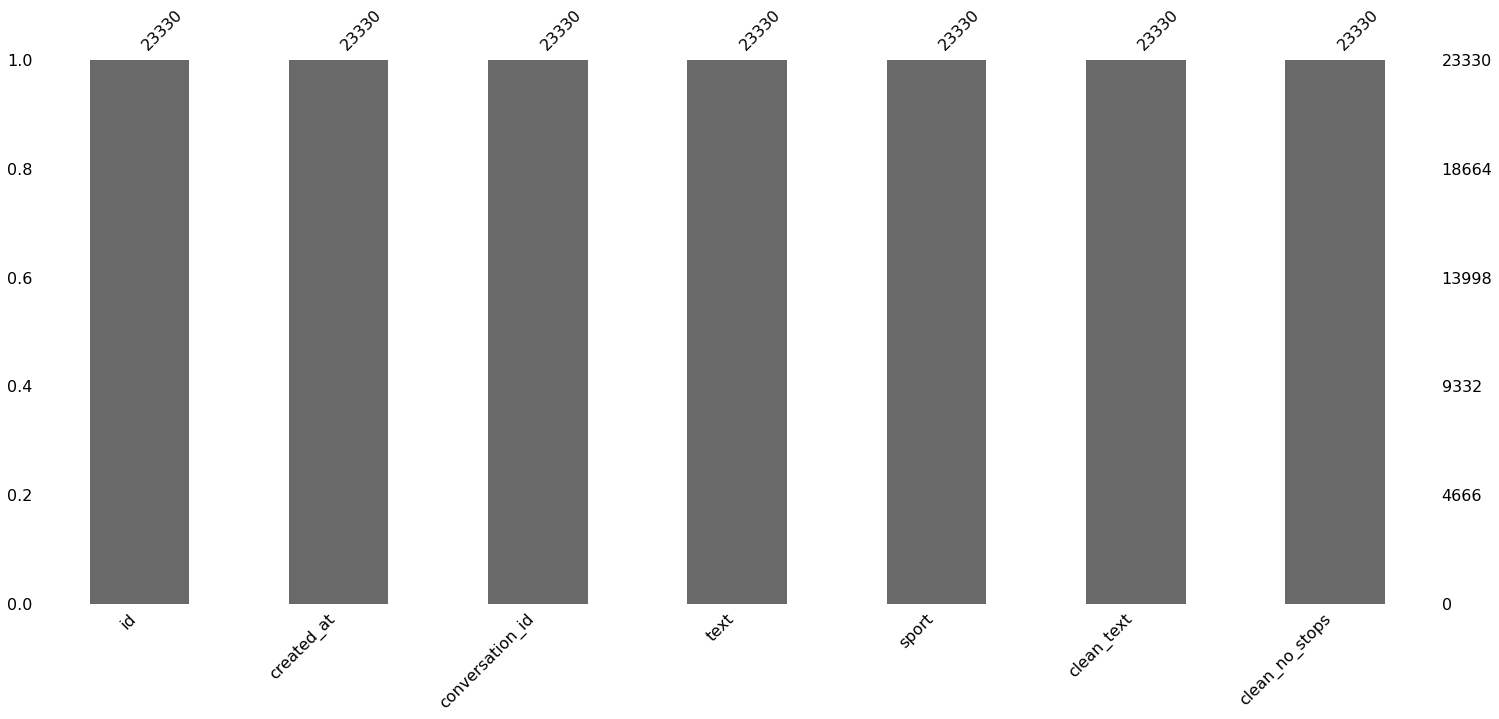

In [20]:
# Barplot for nan counts
import missingno as msno
import matplotlib.pyplot as plt
msno.bar(olympic_df)
plt.show()

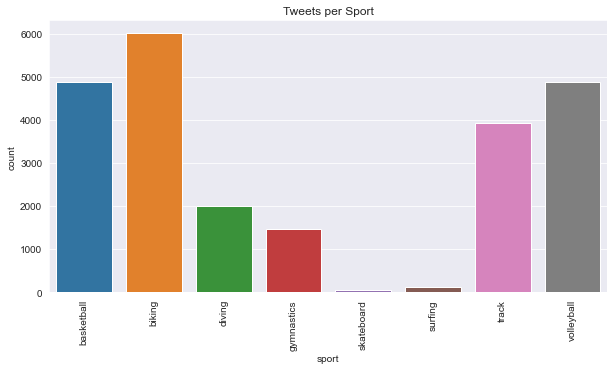

In [21]:
# Barplot for tweets per sport
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x = olympic_df.sport)
plt.xticks(rotation =90)
plt.title("Tweets per Sport")
plt.show()

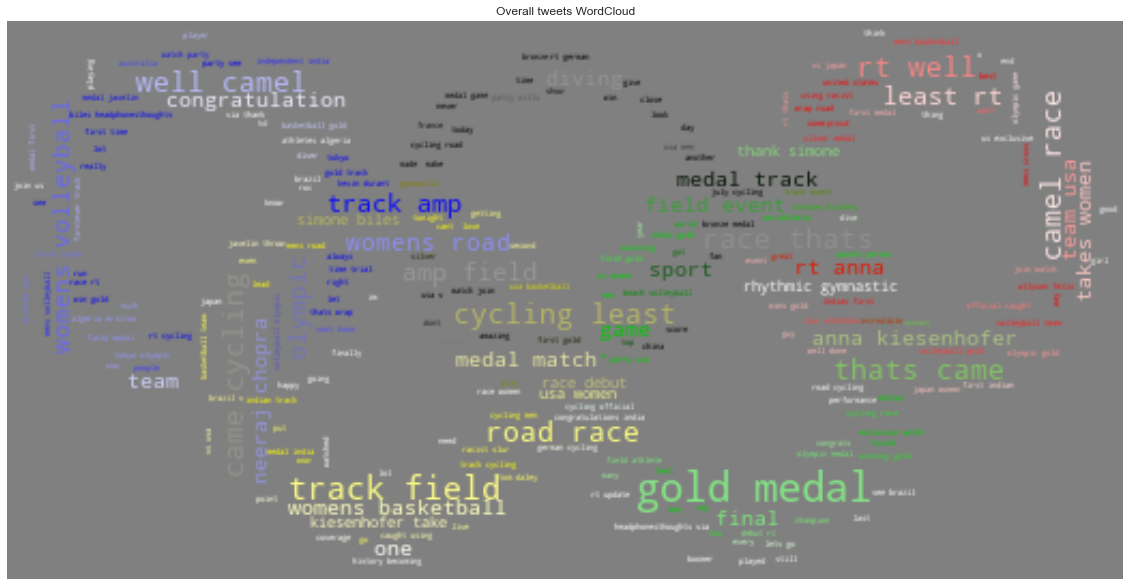

In [23]:
# Wordcloud for all lemmatized tweet words
text = [ ' '.join(tweet) for tweet in olympic_df.clean_no_stops]
mask = np.array(Image.open('../images/Rings2.jpg'))
wordcloud = WordCloud(background_color="gray", mask=mask, max_words=1000).generate(' '.join(text))
colors = ImageColorGenerator(mask)
wordcloud.recolor(color_func=colors)
fig, _ =plt.subplots(figsize=(20,25))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Overall tweets WordCloud')
plt.show()

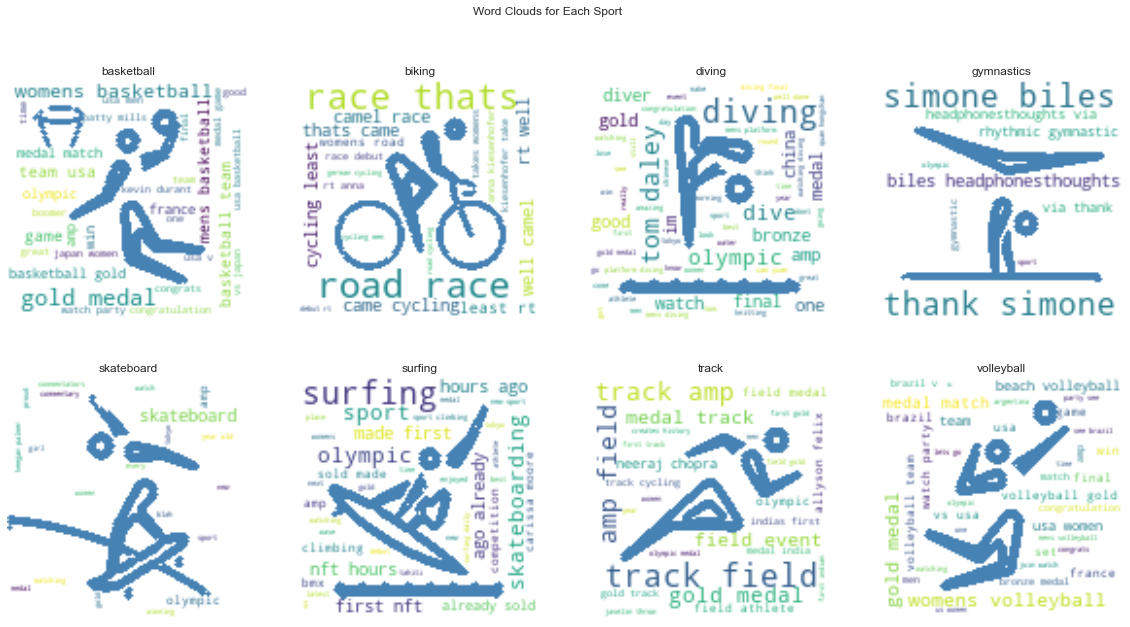

In [24]:
# Individual word clouds by sport
olympic_df.sport.unique()
fig, ax = plt.subplots(2,4, figsize=(20,10))
row = 0
col = 0
for sport in olympic_df.sport.unique():
    sp = olympic_df[olympic_df.sport == sport]
    text = [ ' '.join(tweet) for tweet in sp.clean_no_stops]
    mask = np.array(Image.open('../Images/{}.png'.format(sport)))
    wordcloud = WordCloud(
        background_color="white", mask=mask, contour_width=3, contour_color='steelblue').generate(' '.join(text)
    )
    ax[col, row].imshow(wordcloud, interpolation='bilinear')
    ax[col, row].axis("off")
    ax[col, row].title.set_text('{}'.format(sport))
    row += 1
    if row ==4:
        row =0
        col += 1
plt.suptitle('Word Clouds for Each Sport')
plt.show()

# Lemmatization

Lemmatize words uysing the nlkt Wordnet Lemmatizer.

In [25]:
wn_lemmatizer = WordNetLemmatizer()

olympic_df['lemma_text'] = olympic_df.clean_no_stops.apply(
	lambda text: [ wn_lemmatizer.lemmatize(word, pos='v') for word in text ]
)
olympic_df.sample(5)

,id,created_at,conversation_id,text,sport,clean_text,clean_no_stops,lemma_text
9855,1221988355,2021-07-25 11:58:06+00:00,0,"Australian Anna Kiesenhofer, mathematician by day with two degrees and a PhD, no professional cycling team, wins Ol… https://t.co/ObRP8eNSsW",biking,australian anna kiesenhofer mathematician by day with two degrees and a phd no professional cycling team wins ol,"[australian, anna, kiesenhofer, mathematician, day, two, degrees, phd, professional, cycling, team, wins, ol]","[australian, anna, kiesenhofer, mathematician, day, two, degrees, phd, professional, cycle, team, win, ol]"
21528,-36188157,2021-08-09 18:37:37+00:00,-36188157,"These #Olympics have been so pleasing beyond the track/field/pool etc. The conversations that are now being had around high performance are so important, and can only benefit the sports and those involved in them https://t.co/Huku1mF7XY",track,these have been so pleasing beyond the trackfieldpool etc the conversations that are now being had around high performance are so important and can only benefit the sports and those involved in them,"[pleasing, beyond, trackfieldpool, etc, conversations, around, high, performance, important, benefit, sports, involved]","[please, beyond, trackfieldpool, etc, conversations, around, high, performance, important, benefit, sport, involve]"
27964,-241754108,2021-08-08 00:57:08+00:00,1129684994,@Mariendra 🍿 🤸‍♀️ 🥇 Join us in an exclusive watch party for the Korea 🇰🇷 vs Serbia 🇷🇸 Women's Volleyball Bronze Medal match #Olympics #Tokyo2020 https://t.co/31HGpd5xmk,volleyball,join us in an exclusive watch party for the korea vs serbia womens volleyball bronze medal match,"[join, us, exclusive, watch, party, korea, vs, serbia, womens, volleyball, bronze, medal, match]","[join, us, exclusive, watch, party, korea, vs, serbia, womens, volleyball, bronze, medal, match]"
1430,1213665283,2021-08-08 02:48:53+00:00,1213665283,Japan's SPEED vs USA's HEIGHT. Japan Women's Basketball really has come a long way. My only dream is Gilas Pilipinas Women's basketball reach this kind of goal one day. #olympics,basketball,japans speed vs usas height japan womens basketball really has come a long way my only dream is gilas pilipinas womens basketball reach this kind of goal one day,"[japans, speed, vs, usas, height, japan, womens, basketball, really, come, long, way, dream, gilas, pilipinas, womens, basketball, reach, kind, goal, one, day]","[japan, speed, vs, usas, height, japan, womens, basketball, really, come, long, way, dream, gilas, pilipinas, womens, basketball, reach, kind, goal, one, day]"
22125,-1059606526,2021-08-08 02:20:34+00:00,-1059606526,India won its first gold in track and field and that man absolutely deserved it #Olympics,track,india won its first gold in track and field and that man absolutely deserved it,"[india, first, gold, track, field, man, absolutely, deserved]","[india, first, gold, track, field, man, absolutely, deserve]"


In [27]:
# Cache results
with open('../data/checkpoints/olympic-tweets-pre-sentiment.pkl', 'wb') as f:
	pickle.dump(olympic_df, f)

# Sentiment Analysis

Run pre-trained sentiment analysis with NLTK Vader and store values for sentiment, neg, neu, pos, and compound 

In [28]:
olympic_df = pd.read_pickle('../data/checkpoints/olympic-tweets-pre-sentiment.pkl')

In [29]:
#Calculating Negative, Positive, Neutral and Compound values
olympic_df[['polarity', 'subjectivity']] = olympic_df['lemma_text'].apply(
	lambda text: pd.Series(TextBlob(' '.join(text)).sentiment)
)

for index, row in olympic_df['lemma_text'].iteritems():
	score = SentimentIntensityAnalyzer().polarity_scores(' '.join(row))
	neg = score['neg']
	neu = score['neu']
	pos = score['pos']
	comp = score['compound']

	if neg > pos:
		olympic_df.loc[index, 'sentiment'] = 'negative'
	elif pos > neg:
		olympic_df.loc[index, 'sentiment'] = 'positive'
	else:
		olympic_df.loc[index, 'sentiment'] = 'neutral'
	# # Set the values as columns
	olympic_df.loc[index, 'neg'] = neg
	olympic_df.loc[index, 'neu'] = neu
	olympic_df.loc[index, 'pos'] = pos
	olympic_df.loc[index, 'compound'] = comp

olympic_df.head(10)

,id,created_at,conversation_id,text,sport,clean_text,clean_no_stops,lemma_text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,-1349054463,2021-08-12 18:15:03+00:00,-1349054463,Congratulations to🏅Chelsea Gray🏅on bringing home a Gold Medal for the USA Women’s Basketball team. We are thrilled to see that our wonderful donor was part of the Gold Medal Team!🏅@cgray209\n\n#womensbasketball #chelseagray #goldmedal #2021olympics #chelseagray #olympics #usa https://t.co/hYw94z5jFP,basketball,congratulations tochelsea grayon bringing home a gold medal for the usa womens basketball team we are thrilled to see that our wonderful donor was part of the gold medal team,"[congratulations, tochelsea, grayon, bringing, home, gold, medal, usa, womens, basketball, team, thrilled, see, wonderful, donor, part, gold, medal, team]","[congratulations, tochelsea, grayon, bring, home, gold, medal, usa, womens, basketball, team, thrill, see, wonderful, donor, part, gold, medal, team]",1.000000,1.000000,positive,0.0,0.462,0.538,0.9460
1,429334529,2021-08-12 15:23:44+00:00,429334529,"Talkin’ Noise Podcast - Ep. 9. Will #TeamUSA basketball team win #Gold , Latest on #SIMONEBILES , #NBAFinals wrap up. #nba #Olympics #Greek\n\nhttps://t.co/F3VbB3fnCD https://t.co/1MvdRvYV6p",basketball,talkin noise podcast ep will basketball team win latest on wrap up,"[talkin, noise, podcast, ep, basketball, team, win, latest, wrap]","[talkin, noise, podcast, ep, basketball, team, win, latest, wrap]",0.650000,0.650000,positive,0.0,0.678,0.322,0.5859
2,-48885760,2021-08-12 14:54:47+00:00,-48885760,🔥🔥 High Stakes Takes Locks 🔥🔥\n\nSTILL on a 12 day streak ‼️\n(Chelsea almost blew it 😂😂)\n\nDodgers +100 @ Phillies LIVE ✅\n\nDC United +185 vs cf MTL LIVE ✅\n\n#GamblingTwitter #bettingtips #FreePicks #OlympicGames #Olympics #Tokyo2020 #Basketball #NBA #UEFASuperCup https://t.co/pJiv3y6sFE,basketball,high stakes takes locks still on a day streak chelsea almost blew it dodgers phillies live dc united vs cf mtl live,"[high, stakes, takes, locks, still, day, streak, chelsea, almost, blew, dodgers, phillies, live, dc, united, vs, cf, mtl, live]","[high, stake, take, lock, still, day, streak, chelsea, almost, blow, dodgers, phillies, live, dc, unite, vs, cf, mtl, live]",0.144242,0.513333,neutral,0.0,1.000,0.000,0.0000
3,2115334144,2021-08-12 13:02:47+00:00,2115334144,Thursday Q&amp;A\n\nClick the link in the bio!\n\n#FAQs #QTNA #QandA #ncaa #psacm #studentathlete #athlete #basketball #football #baseball #softball #soccer #gymnastics #trackandfield #olympics #volleyball #swimming #golf #tennis #wrestling #lacrosse #ncaanews #ncaarules #scholarship # https://t.co/JEt4N4xbk9,basketball,thursday qampaclick the link in the bio,"[thursday, qampaclick, link, bio]","[thursday, qampaclick, link, bio]",0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000
4,-183029759,2021-08-12 12:36:07+00:00,-183029759,My 1st of three #Olympics themed articles in this week's @NYAmNews focuses on the amazing @usabasketball women's team. U.S. women’s basketball team wins seventh straight gold https://t.co/kHQnUngJFi,basketball,my st of three themed articles in this weeks focuses on the amazing womens team us womens basketball team wins seventh straight gold,"[st, three, themed, articles, weeks, focuses, amazing, womens, team, us, womens, basketball, team, wins, seventh, straight, gold]","[st, three, theme, article, weeks, focus, amaze, womens, team, us, womens, basketball, team, win, seventh, straight, gold]",0.500000,0.400000,positive,0.0,0.603,0.397,0.8481
5,-1944776702,2021-08-12 12:26:43+00:00,-1944776702,Great little video about the legend that is Patty #Mills for those looking for a little post #Olympics high https://t.co/CsQuS1sH2m #basketball #Alpha,basketball,great little video about the legend that is patty for those looking for a little post high,"[great, little, video, legend, patty, looking, little, post, high]","[great, little, video, legend, patty, look, little, post, high]",0.146250,0.572500,p

In [30]:
# Cache results
with open('../data/checkpoints/olympic-tweets-post-sentiment.pkl', 'wb') as f:
	pickle.dump(olympic_df, f)

# Visualizations & Analysis

In [31]:
olympic_df = pd.read_pickle('../data/checkpoints/olympic-tweets-post-sentiment.pkl')

In [32]:
# Create ancillary dataframes for plotting
scatter_df = olympic_df[['id', 'sentiment', 'polarity', 'compound', 'sport']]
df = olympic_df[['id','sentiment', 'sport']]
bar_df = pd.DataFrame(df.groupby(by=['sport', 'sentiment'])['id'].count()).reset_index()

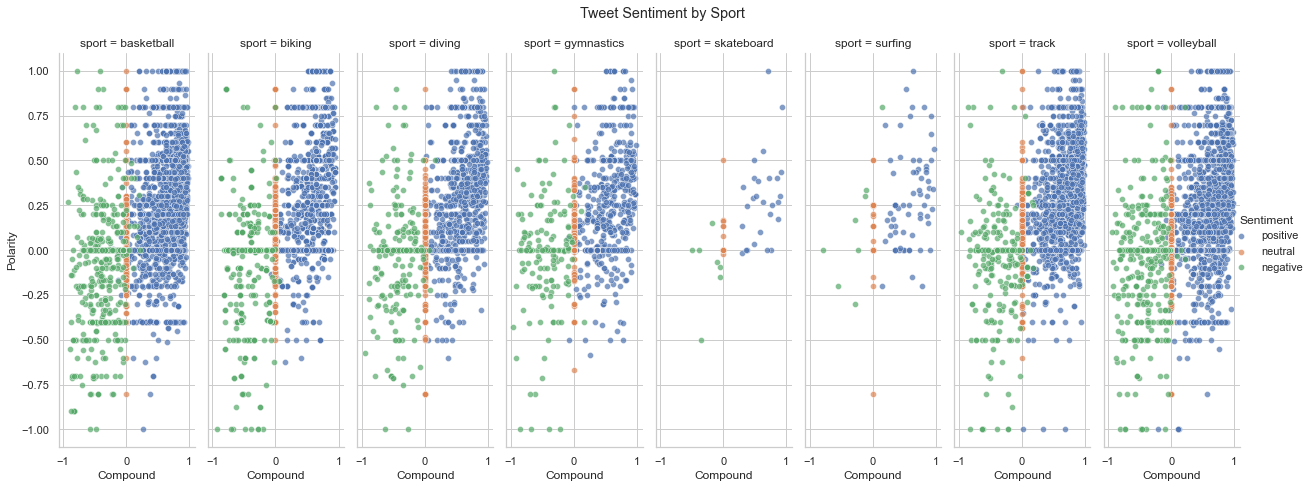

In [33]:
# Scatter plots for compound and polarity
sns.set_theme(style='whitegrid')

g = sns.FacetGrid(data=scatter_df, col='sport', hue='sentiment')
g.map(sns.scatterplot, 'compound', 'polarity', alpha=0.7)
g.add_legend(title='Sentiment')
g.set_axis_labels(x_var='Compound', y_var='Polarity')
g.fig.suptitle('Tweet Sentiment by Sport')
plt.subplots_adjust(top=0.9)
g.fig.set_size_inches(18, 8)


Text(0, 0.5, 'Percentage')

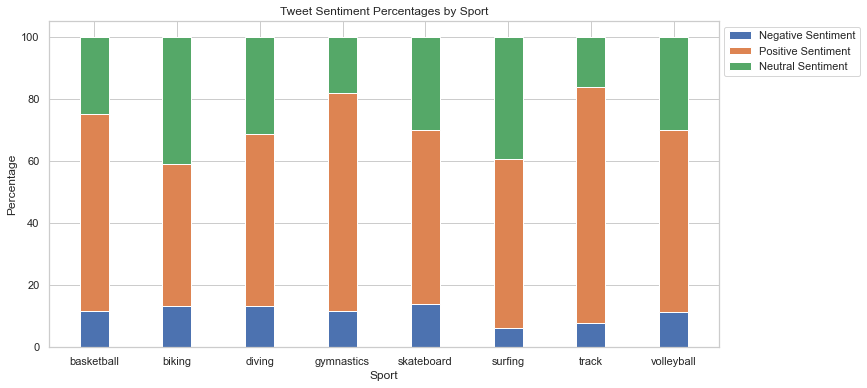

In [34]:
# Bar plots for sentiment distribution
neg = bar_df.id[bar_df.sentiment == 'negative'].values
pos = bar_df.id[bar_df.sentiment == 'positive'].values
neu = bar_df.id[bar_df.sentiment == 'neutral'].values

totals = [ i + j + k for i, j, k in zip(neg, pos, neu) ]
neg_adj = [ i / j * 100 for i, j in zip(neg, totals) ]
pos_adj = [ i / j * 100 for i, j in zip(pos, totals) ]
neu_adj = [ i / j * 100 for i, j in zip(neu, totals) ]

labels = list(olympic_df.sport.unique())

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(labels, neg_adj, width=0.35, label='Negative Sentiment')
ax.bar(labels, pos_adj, width=0.35, bottom=neg_adj, label='Positive Sentiment')
ax.bar(labels, neu_adj, width=0.35, bottom=[i + j for i,j in zip(neg_adj, pos_adj)], label='Neutral Sentiment')

plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=1)
plt.title('Tweet Sentiment Percentages by Sport')
plt.xlabel('Sport')
plt.ylabel('Percentage')